# MS2 processing

This is work in progress, so it's not really set up for others to use and descriptions are weak. The input data is 2-channel fluorescence microscopy movies of fly embryos. In one channel is a nuclear-protein (which marks nuclei and is also interesting in its own right), and in the other channel are "MS2" spots, which are individual transcribed genes. The intensity of the spot corresponds to how actively the gene is being transcribed. The resulting data give us a real time readout of gene transcription. The computational challenge is to segment nuclei, detect MS2 spots, and quantify the fluorescence intensity of those spots. I also do some correcting of those measurements (for bleaching and sample depth), but I'm working on those and they're not quite ready.

I wrote everything with the idea of being used in an interactive notebook. The reason is that the data are not (yet) standardized. I potentially want to analyze data with different resolutions, fields of view, nuclear sizes (a function of the developmental stage of the embryo), nuclear proteins (which protein is fluorescently labeled), laser intensities (influencing signal intensity and contrast), and other variables. As such it isn't currently set up to be a single command-line pipeline where you input files and it spits out processed data. I expect the user to tweak parameters at various steps to get it to work for a given dataset. Eventually, some of these experiments might get standardized to that point, and alternately good enough code could probably work that way.

The notebook calls functions from the imagep.py file (located in bin/), and imagep.py requires the file fitting.py (also in bin) to be in the same directory. The dependencies are also probably going to be hell -- it seems that for anyone else to use, putting it in a docker container would be helpful. Anyway, this is its current state.

## 0. Set files

Example data files can be downloaded at https://berkeley.box.com/s/gece4vm6k5e4o16f0x79irmr2bmi9ue9

There are 5 files (consecutive movies -- we periodically re-adjust the Z position to account for drift), but you don't need to do all 5. The first 2 will suffice.

In [1]:
# Set channels corresponding to nuclear signal and MS2 spots.
nucchannel = 0
spotchannel = 1
# Set paths for output movie object, input files, and bin.
mv_filename = ''
czi_folder_path = '/Volumes/Stadler100/2021-03-11'
bin_path = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin'

czi_files = ['20210311-Rpb1GFP-HbMS2-em1-zsmv-03.czi',
             '20210311-Rpb1GFP-HbMS2-em1-zsmv-04.czi',
             '20210311-Rpb1GFP-HbMS2-em1-zsmv-05.czi',
             '20210311-Rpb1GFP-HbMS2-em1-zsmv-06.czi',
             '20210311-Rpb1GFP-HbMS2-em1-zsmv-07.czi',
            ]

In [2]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import czifile
import sys
import xml.etree.ElementTree as ET
%matplotlib inline

# Import my packages.
sys.path.append(bin_path)
import imagep as imp
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

## 1. Read input files

In [3]:
# Read and join czi files into single image stack, recording frames at which movies
# are joined and starting Z positions.
stack, join_frames, starting_positions = imp.read_czi_multiple(czi_files, czi_folder_path)

In [4]:
# Take a look at the data
viewer(stack, zmax=True)

interactive(children=(Dropdown(description='Color', index=4, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

## 2. Nuclear Segmentation
### 2-1 Determine parameters for segmentation of nuclei.

In [5]:
# Perform initial nuclear segmentation using the first few frames to determine parameters.
seed_window = (30,30)
min_seed_dist = 30
sigma = 5
usemax = True

# Descriptions of parameters:
#?imp.segment_nuclei_3Dstack_rpb1

In [6]:
nucmask_test = imp.segment_nuclei_4dstack(stack[nucchannel, 6:7], imp.segment_nuclei_3Dstack_rpb1, seed_window=seed_window, min_seed_dist=min_seed_dist, sigma=sigma, usemax=usemax)
viewer(nucmask_test, color='prism')

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

### 2-2. Perform initial segmentation, filtering, and connect nuclei

In [7]:
# Segment nuclei using parameters determined above.
nucmask_init = imp.segment_nuclei_4dstack(stack[nucchannel], imp.segment_nuclei_3Dstack_rpb1, seed_window=seed_window, min_seed_dist=min_seed_dist, sigma=sigma, usemax=usemax)
viewer(nucmask_init, color='prism')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 


interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

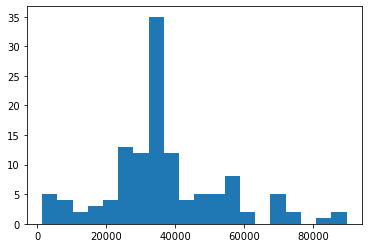

In [8]:
# Glance at histogram of object sizes.
plt.hist(np.unique(nucmask_init[0], return_counts=True)[1], bins=20);

In [9]:
# Filter segmented nuclei based on their size.
size_min = 0
size_max = 50000

nucmask_sizefiltered = imp.labelmask_filter_objsize_apply4d(nucmask_init, size_min, size_max)

viewer(nucmask_sizefiltered, color="prism")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

In [10]:
# Filter segmented nuclei based on circularity (0-1).
slicenum = 6 # Z slice to use for circularity -- irrelevant if using max projections.
circularity_min = 0.7

nucmask_filtercirc = imp.filter_labelmask_circularity_apply4d(nucmask_sizefiltered, slicenum=slicenum, 
    circularity_min=circularity_min)

viewer(nucmask_filtercirc, color="prism")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

In [11]:
# Connect nuclei between frames.
max_frames_skipped = 2

nucmask_conn = imp.connect_nuclei(nucmask_filtercirc, max_frames_skipped=max_frames_skipped, usemax=True)
viewer(nucmask_conn, color='prism')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

interactive(children=(Dropdown(description='Color', index=7, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

### 2-3. Interpolate to fill in gaps

Working on this, currently nonfunctional.

In [12]:
#nucmask = imp.interpolate_nuclear_mask(nucmask_conn, 3, usemax=True)
nucmask = nucmask_conn

## 3. Detecting MS2 spots
### 3-1 Perform gaussian fitting on MS2 channel

In [13]:
min_distances = (stack.shape[-2], 25, 25)
fitwindow_rad_xy = 10
fitwindow_rad_z = 2
sigma_small = 1

fits = imp.fit_ms2(stack[spotchannel], min_distances=min_distances, fitwindow_rad_xy=fitwindow_rad_xy, sigma_small=sigma_small)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

### 3-2 Filter fits

In [14]:
# Parameters for filtering fit
peakiness = 4.2
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack, spotchannel)
imp.quickview_ms2(stack, fits_filtered, 1)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2211: RuntimeWarning: divide by zero encountered in log
  spot_peakiness = np.log(peak_heights / xy_width_means)


interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

### 3-3 Connect spots between frames

In [15]:
# Connect all frames.
spots_connected = imp.connect_ms2_frames_via_nuclei(fits_filtered, nucmask, nucmask_dilation=10)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

### 3-4 Filter detected spots

In [16]:
# Filter for trajectory length.
min_len = 10

spot_data = imp.filter_spot_duration(spots_connected, min_len)

In [17]:
# Check the results.
imp.quickview_ms2(stack, spot_data, channel = spotchannel, MAX=True)

interactive(children=(Dropdown(description='Color', index=5, options=('gray', 'magma', 'Gators', 'gray_r', 'Gr…

## 4. Integrate signal around spots, apply corrections.
### 4-1. Integrate MS2 signal
__*Integrated volume of MS2 signal: finds mean signal (in un-processed data) of an ellipsoid centered at the spot center*__

In [18]:
ij_rad = 6
z_rad = 1.1
ij_scale = 1
z_scale = 1

spot_data2 = imp.add_volume_mean(spot_data, stack, spotchannel, ij_rad, z_rad, ij_scale, z_scale)

10 20 30 40 50 

### 4-2 Integrate gaussian fits
__*Integrates the 'area under the curve'&ast; of the gaussian fit*__

In [19]:
wlength_ij = 13
wlength_z = 3
reload(imp)
spot_data3 = imp.add_gaussian_integration(spot_data2, wlength_ij, wlength_z)

### 4-3 Integrate signal from protein channel
__*Integrated volume of protein signal: finds mean signal (in un-processed data) of an ellipsoid centered at the spot center*__

In [20]:
ij_rad = 3
z_rad = 1.1
ij_scale = 1
z_scale = 1

spot_data4 = imp.add_volume_mean(spot_data3, stack, nucchannel, ij_rad, z_rad, ij_scale, z_scale)

10 20 30 40 50 

### 4-4. Package into *movie* object.

In [21]:
mv = imp.movie(stack, nucmask, fits, spot_data4)

### 4-5 Perform corrections

(This section under construction)

Plan for Z corrections:

- Before and after dataset, record position of embryo surface in microns.  
- Pull Z stack start positions from czi metadata for each movie.
- Assume that drift is linear. Combination of start positions and calculated "true" embryo position should give something close to a real embryo depth measurement for each Z position in the dataset. 

How to apply this in code?

In [ ]:
# Get z increment (in microns) from metadata.
"""
metadata = czifile.CziFile(czi_file).metadata()
root = ET.fromstring(metadata)
z_increment = float(root[0][4][3][11][5][3][0][1].text)
print(z_increment)
"""

In [ ]:
# Generate new dataframes using z depth correction calibration.
"""
slope = -338
slice_thickness = z_increment
mv.intvol_zc, mv.intfit_zc, mv.prot_zc = imp.correct_spot_data_depth(mv.spot_data, slope=slope, slice_thickness=slice_thickness, 
    cols=[9,10,11], return_dfs=True)
"""

In [ ]:
#mv.intvol_bzc = imp.spotdf_bleach_correct(mv.intvol_zc, mv.stack[nucchannel])
#mv.intfit_bzc = imp.spotdf_bleach_correct(mv.intfit_zc, mv.stack[nucchannel])
#mv.prot_bzc = imp.spotdf_bleach_correct(mv.prot_zc, mv.stack[nucchannel])

In [22]:
mv.intvol_bc = imp.spotdf_bleach_correct(mv.intvol, mv.stack[nucchannel])
mv.intfit_bc = imp.spotdf_bleach_correct(mv.intfit, mv.stack[nucchannel])
mv.prot_bc = imp.spotdf_bleach_correct(mv.prot, mv.stack[nucchannel])

In [ ]:
save_pickle(mv, mv_filename)

## 5. QC

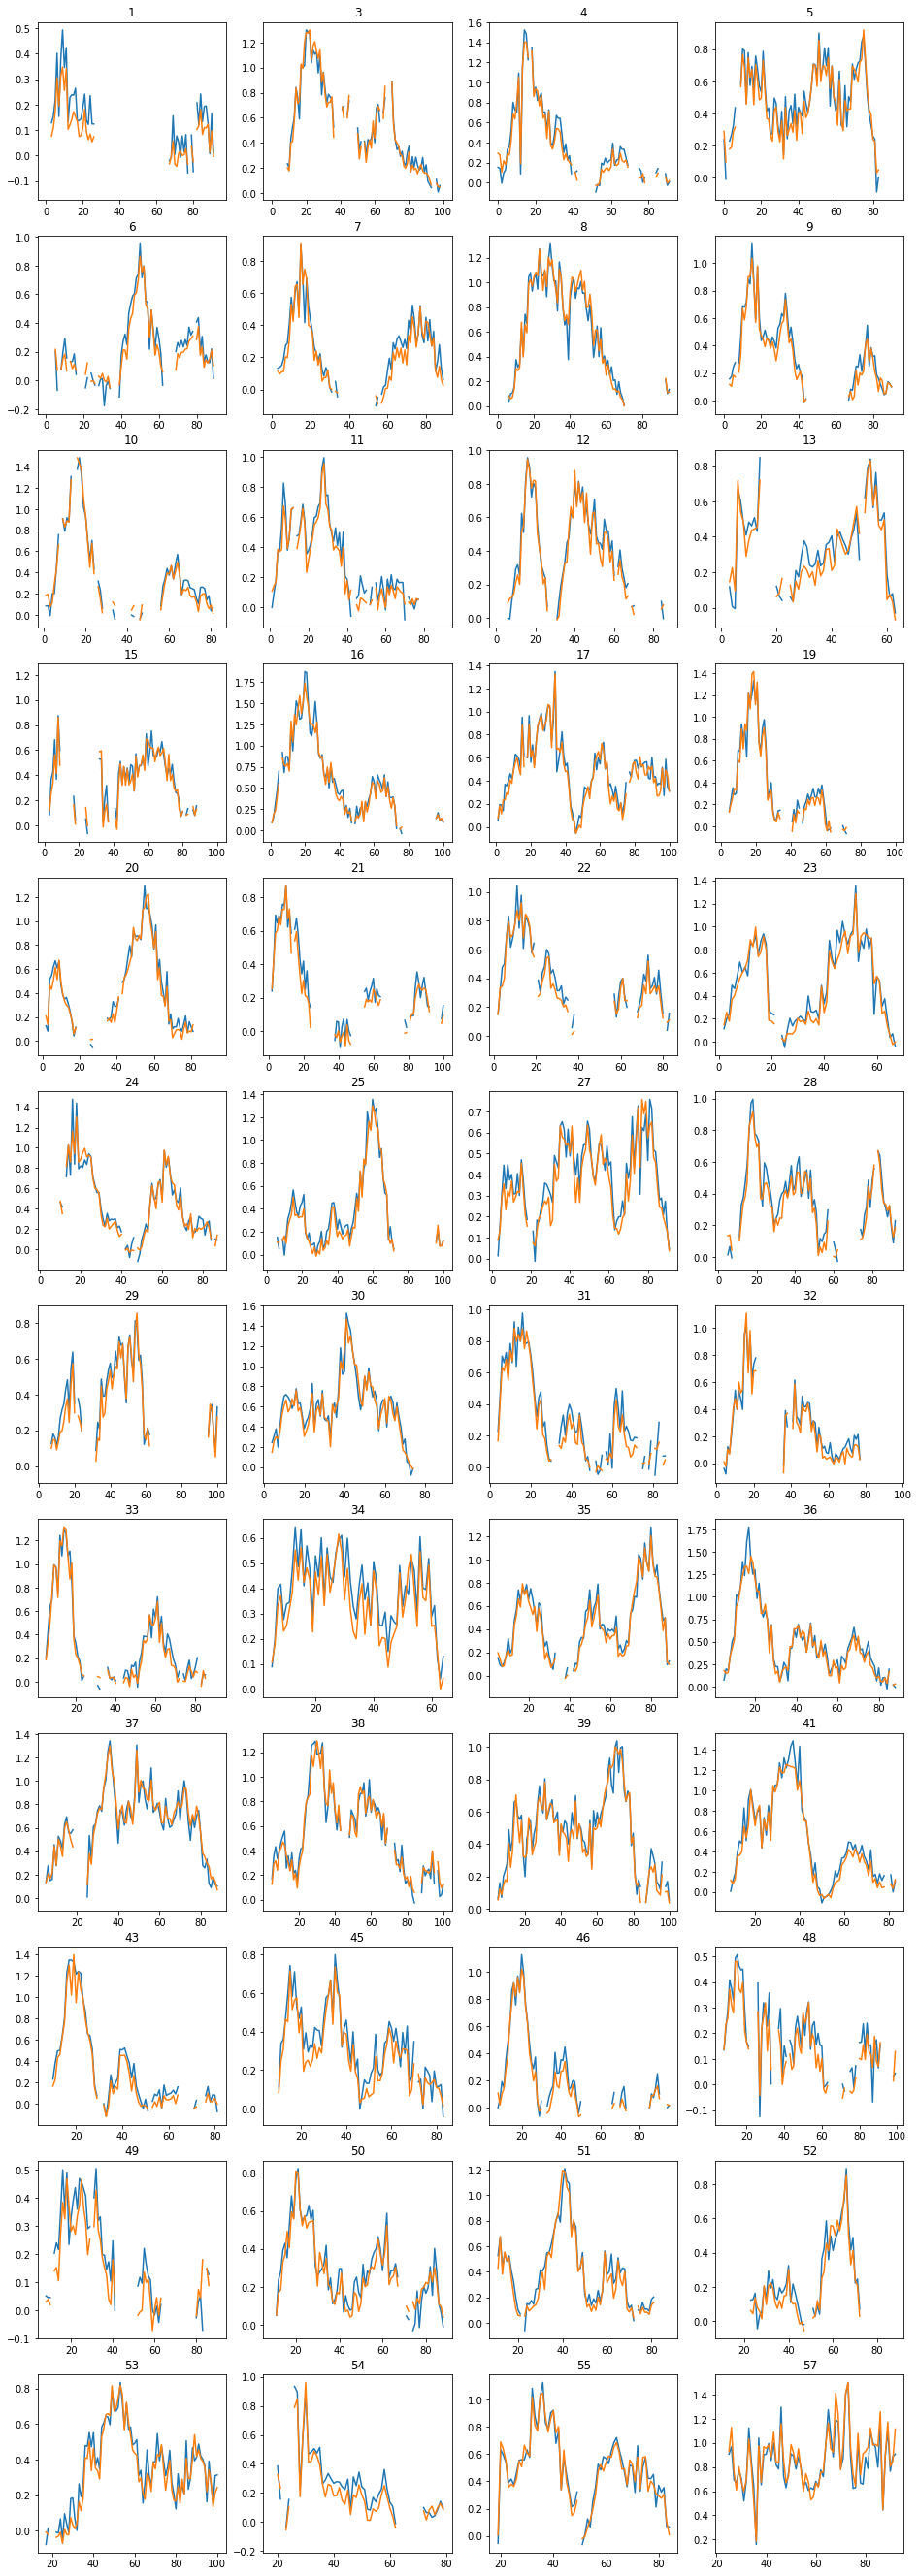

In [24]:
# Plot some traces to see if they look reasonable.
imp.spotdf_plot_traces(mv.intvol_bc, mv.intfit_bc, 50, sigma=0.1)

<ipython-input-25-c6ced7f6df45>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


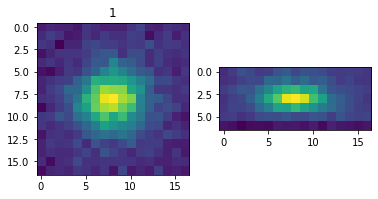

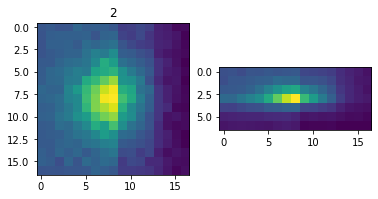

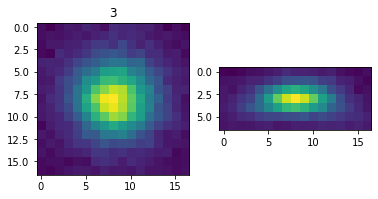

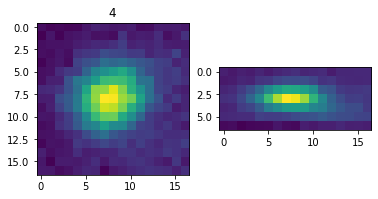

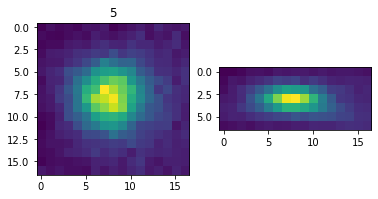

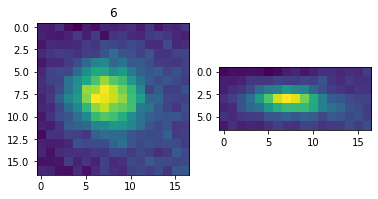

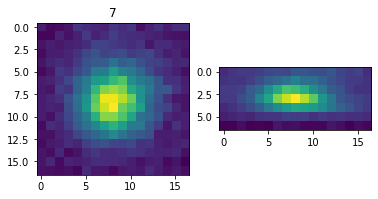

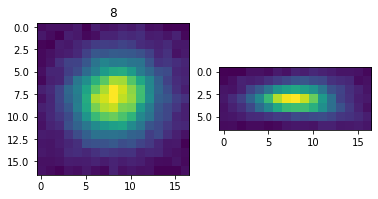

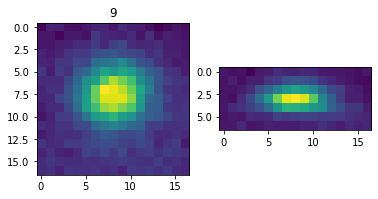

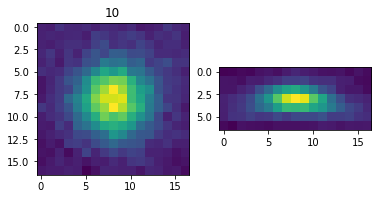

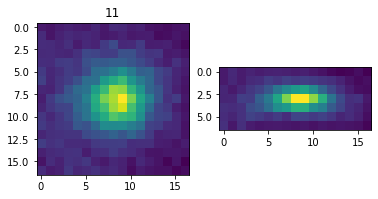

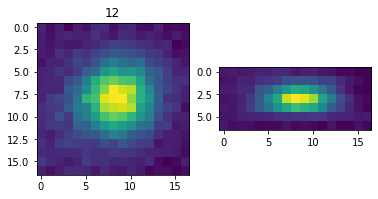

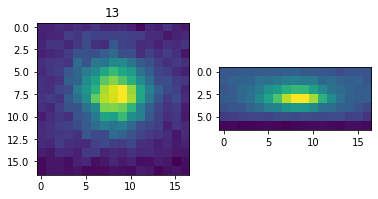

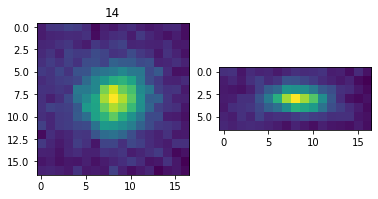

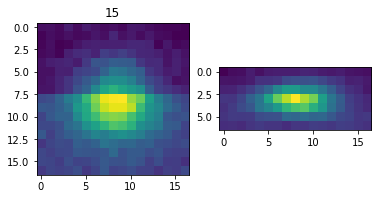

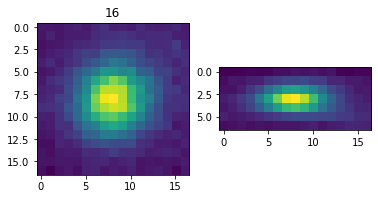

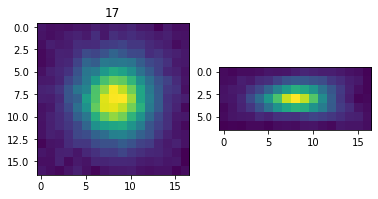

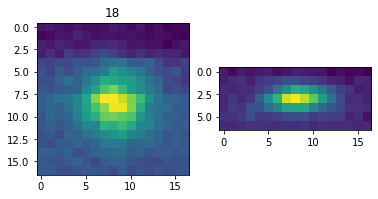

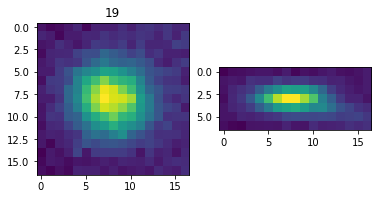

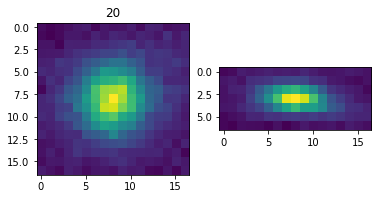

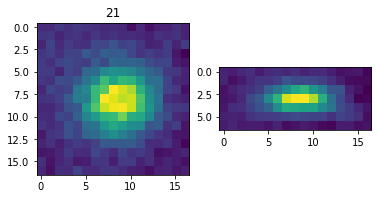

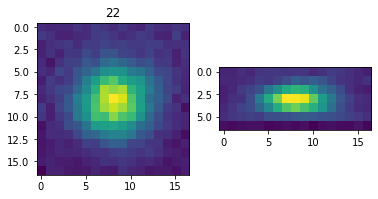

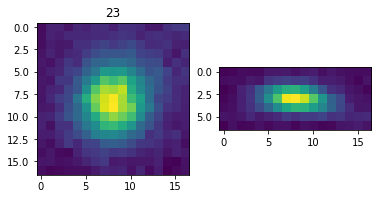

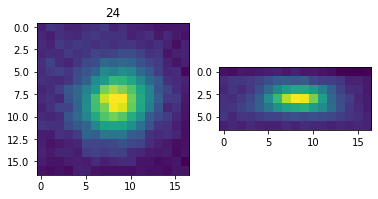

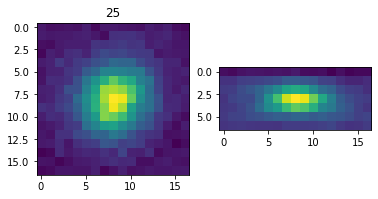

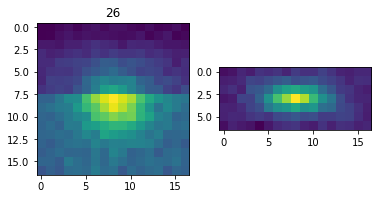

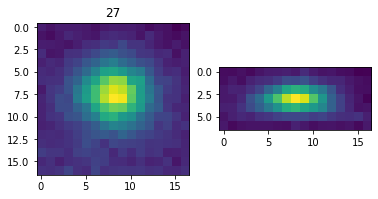

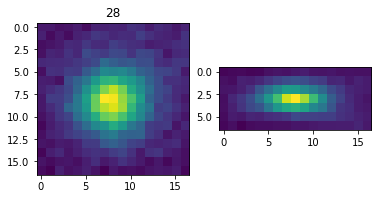

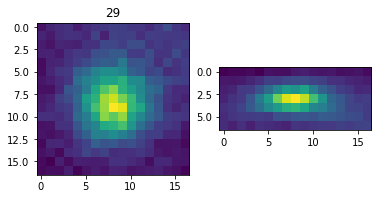

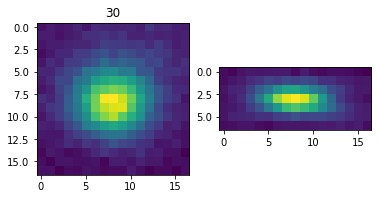

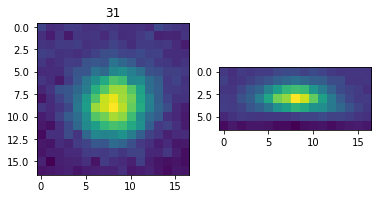

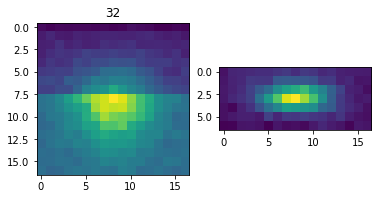

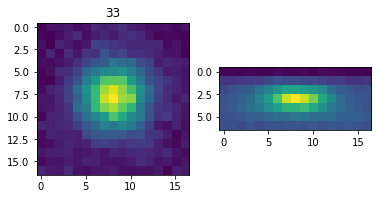

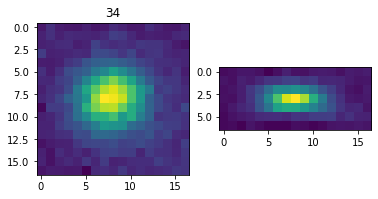

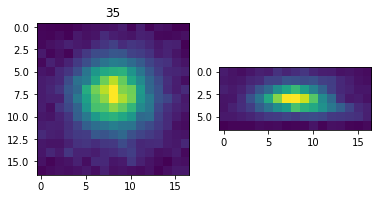

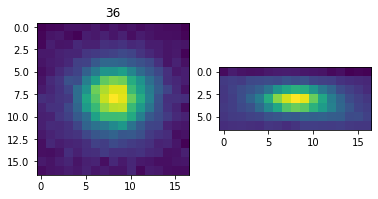

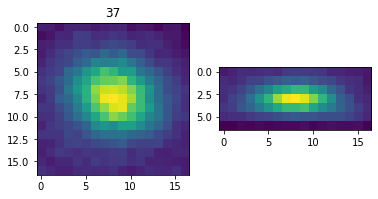

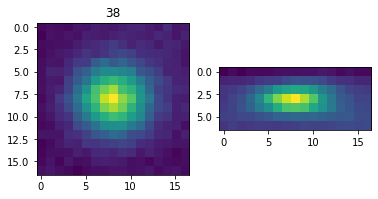

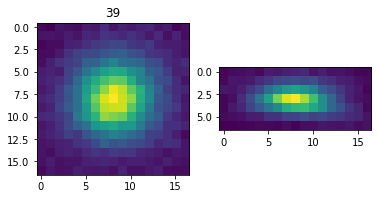

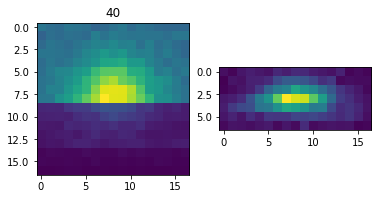

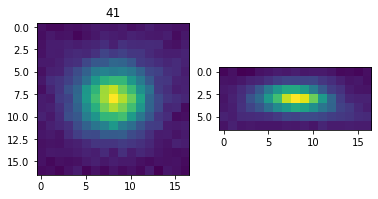

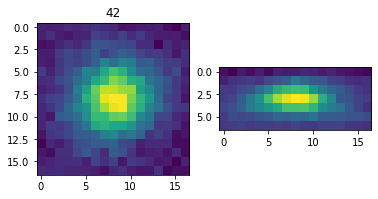

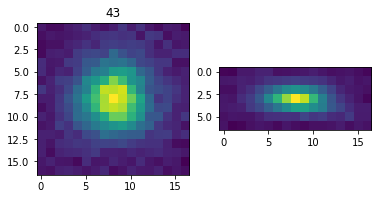

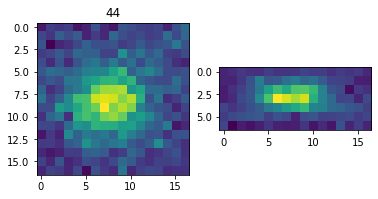

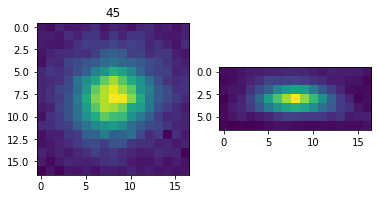

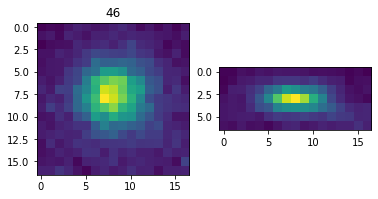

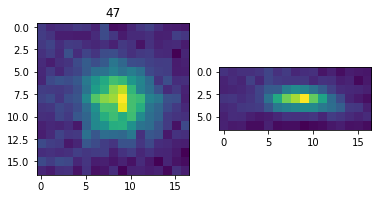

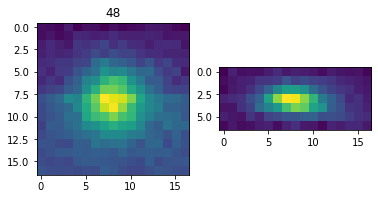

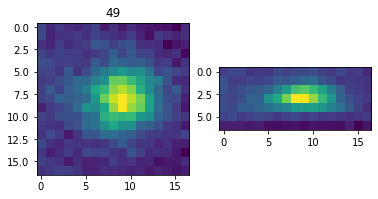

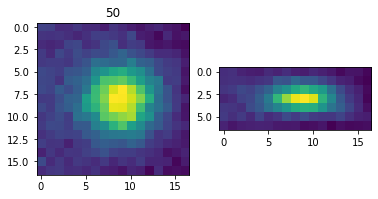

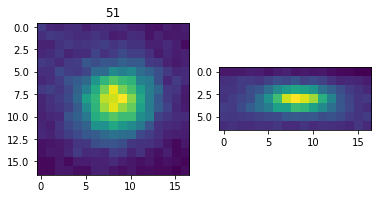

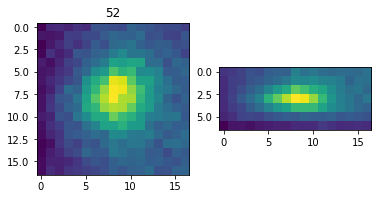

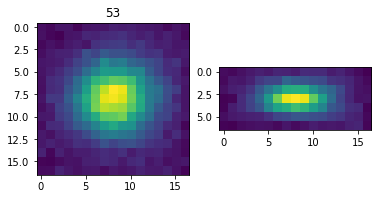

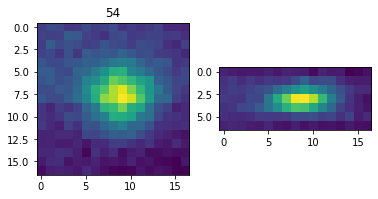

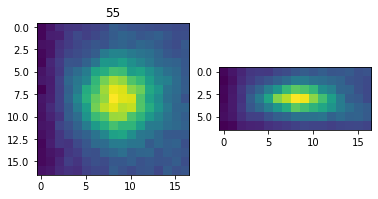

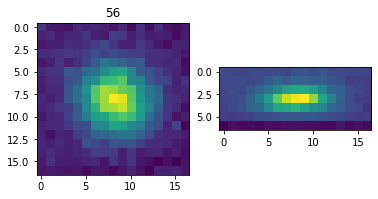

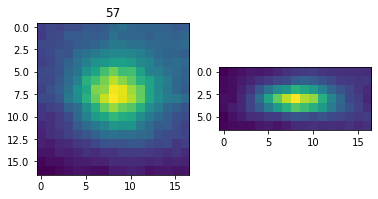

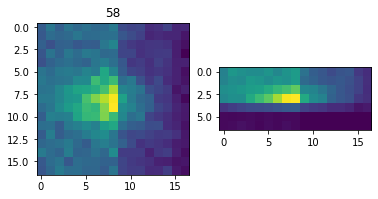

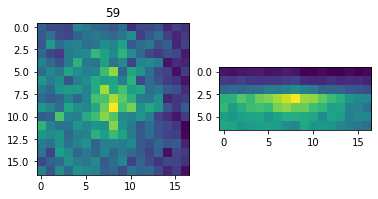

In [25]:
# Examine time-averaged xy (Z-projection) and xz views of each spot.
sm = imp.spot_movies(mv.stack, mv.spot_data, 1,17, fill=0, view=False)
# Note: put this in a function.
for x in range(1,len(sm)):
    xy = sm[x].mean(axis=(0,1))
    xz = sm[x].mean(axis=(0,2))
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(xy)
    ax[0].set_title(x)
    ax[1].imshow(xz)


In [ ]:
# View "spot movies", small boxes of stack data centered on detected spots.
spot_movies = imp.spot_movies(mv.stack, mv.spot_data, channel=1, len_ij=51, fill=0)
# Mean projection of z slices -1 to +1:
viewer(spot_movies[:,:,2:5].mean(axis=2), 5, order='ntxy', color='cividis')
# No projection (with Z axis):
#viewer(spot_movies, 5, order='ntzxy', color='cividis')

In [ ]:
# Optional: Examine individual spots in original data.
spot_to_view = 29
imp.quickview_ms2(mv.stack, mv.spot_data, channel=1, spot_id=spot_to_view, MAX=True)